In [1]:
import datetime
import gc
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

data_dir = Path.home() / 'Desktop/kaggle/data/lanl'
os.environ['DATA_DIR'] = str(data_dir)

In [2]:
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import model_selection, preprocessing, metrics

import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
X_train = pd.read_pickle(data_dir / 'df_xtrain_extra_v5.pickle')
X_test = pd.read_pickle(data_dir / 'df_xtest_extra_v5.pickle')

In [4]:
X_train.shape

(16626, 382)

In [5]:
X_test.shape

(2624, 382)

In [6]:
DISCARDED_INDEX = []
DISCARDED_INDEX_ = [
    53, 54, 55, 83, 84, 90, 206, 208, 214, 234, 241, 242, 248, 249,
       251, 252, 253, 257, 266, 271, 305, 312, 313, 314, 369, 433, 434,
       448, 451, 459, 460, 461, 462, 463, 464, 465, 482, 483, 484, 485,
       492, 502, 506, 513, 517, 529, 531, 532, 534, 536, 541, 542, 549,
       556, 569, 570, 571, 572, 577, 578, 581, 582, 584, 585, 587, 594,
       595, 597, 599, 600, 604, 606, 607, 608, 611, 614, 617, 621, 628,
       630, 631, 632, 633, 634, 636, 640, 641, 642, 643, 646, 647, 654,
       655, 656, 657, 663, 665, 666, 668, 670, 675, 678, 681, 683, 687,
       688, 689, 691, 693, 694, 695, 696, 699, 700, 701, 702, 704, 706,
       708, 709, 714, 715, 719, 723, 726, 732, 734, 739, 740, 741, 744,
       752, 755, 760, 763, 764, 771, 772, 787, 790, 798, 800, 801, 803,
       804, 805, 808, 813, 816, 817, 818, 819, 820, 822, 823, 832, 834,
       837, 838, 840, 853, 908, 913, 918, 919, 920, 924, 925, 928, 929,
       930, 932, 933, 934, 936, 940, 945, 946, 947, 948, 953, 955, 956,
       957, 959, 961, 962, 963, 966, 969, 971, 972, 974, 976, 977, 994,
       998, 1000, 1004, 1005, 1006, 1007, 1008, 1010, 1016, 1020, 1021,
       1026, 1027, 1030, 1033, 1035, 1045, 1068, 1087, 1104, 1113, 1114,
       1115, 1116, 1117, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1130,
       1134, 1145, 1146, 1147, 1148, 1152, 1153, 1162, 1165, 1167, 1168,
       1172, 1177, 1178, 1186, 1187, 1189, 1198, 1199, 1205, 1208, 1209,
       1210, 1214, 1215, 1216, 1217, 1230, 1234, 1240, 1242, 1245, 1251,
       1252, 1254, 1255, 1256, 1258, 1268, 1273, 1275, 1276, 1281, 1282,
       1294, 1307, 1308, 1311, 1312, 1313, 1314, 1316, 1321, 1331, 1337,
       1342, 1354, 1360, 1469, 1481, 1501, 1505, 1508, 1524, 1541, 1556,
       1561, 1620, 1715, 1802, 1811, 1814, 1816, 1817, 1820, 1822, 1827,
       1844, 1846, 1848, 1851, 1853, 1854, 1855, 1858, 1861, 1863, 1864,
       1865, 1866, 2290, 2537, 2610, 2611, 2627, 2694, 2700, 2764, 2773,
       2779, 2780, 2781, 2782, 2783, 2795, 2810, 2811, 2814, 2818, 2820,
       2898, 2931, 2932, 2934, 2948, 2952, 2953, 2957, 2958, 2994, 2999,
       3002, 3053, 3168, 3199, 3207, 3208, 3209, 3226, 3228, 3241, 3243,
       3454, 3477, 3479, 3484, 3486, 3488, 3489, 3490, 3493, 3494, 3495,
       3498, 3516, 3520, 3529, 3550, 3551, 3562, 3580, 3581, 3586, 3587,
       3604, 3676, 3677, 3679, 3711, 3794, 3798, 3799, 3804, 3817, 3818,
       3823, 3825, 3831, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3844,
       3845, 3849, 3850, 3860, 3861, 3862, 3865, 3867, 3881, 3884, 3885,
       3888, 3892, 3894, 3895, 3896, 3901, 3902, 3905, 3906, 3924, 3925,
       3948, 3970, 3982, 3986, 3987, 3988, 3991, 4003, 4008, 4017, 4018,
       4019, 4020, 4032, 4035, 4048, 4055, 4056, 4057, 4069, 4071, 4073,
       4081, 4082, 4083, 4084, 4087, 4088, 4089, 4094, 4102, 4103, 4106,
       4116, 4119, 4121, 4123, 4141, 4142, 4181, 4188, 4189, 4193, 4194,
       4195, 4196, 4208, 4233, 4241, 4280, 4288, 4311, 4371, 4381, 4382,
       4387, 4388, 4394, 4398, 4400, 4401, 4405, 4417, 4424, 4440, 4783,
       4786, 5115
] + [
    15, 37, 38, 39, 48, 69, 77, 88, 89, 108, 207, 222, 229, 230, 244,
       250, 264, 269, 278, 282, 316, 323, 324, 372, 404, 427, 429, 449,
       453, 455, 458, 470, 476, 479, 480, 486, 487, 490, 493, 494, 505,
       511, 520, 527, 537, 538, 540, 548, 555, 568, 573, 576, 583, 588,
       590, 596, 603, 605, 609, 612, 613, 618, 619, 620, 622, 626, 627,
       635, 639, 644, 645, 648, 649, 650, 652, 659, 662, 669, 673, 674,
       677, 682, 685, 692, 703, 705, 707, 710, 712, 713, 717, 718, 725,
       727, 728, 736, 737, 738, 742, 743, 745, 754, 761, 765, 770, 786,
       788, 793, 796, 797, 802, 807, 809, 810, 811, 812, 815, 821, 824,
       827, 830, 831, 833, 839, 852, 874, 881, 884, 885, 903, 904, 907,
       911, 912, 914, 916, 917, 921, 935, 939, 943, 949, 951, 952, 954,
       960, 964, 965, 968, 970, 973, 975, 985, 987, 988, 996, 999, 1009,
       1019, 1024, 1025, 1028, 1032, 1038, 1042, 1044, 1061, 1086, 1088,
       1098, 1100, 1103, 1105, 1106, 1111, 1118, 1119, 1120, 1135, 1149,
       1151, 1155, 1157, 1158, 1160, 1164, 1166, 1176, 1184, 1188, 1190,
       1192, 1197, 1200, 1203, 1204, 1213, 1220, 1221, 1223, 1236, 1239,
       1241, 1246, 1248, 1257, 1259, 1260, 1271, 1272, 1274, 1283, 1286,
       1295, 1304, 1309, 1310, 1318, 1319, 1329, 1343, 1344, 1468, 1482,
       1483, 1484, 1518, 1525, 1527, 1559, 1560, 1562, 1574, 1684, 1685,
       1710, 1711, 1714, 1748, 1753, 1766, 1808, 1810, 1813, 1818, 1819,
       1821, 1828, 1829, 1834, 1837, 1843, 1850, 1856, 1857, 1859, 1860,
       1862, 1868, 1879, 2124, 2125, 2217, 2219, 2264, 2265, 2270, 2273,
       2291, 2292, 2295, 2296, 2388, 2389, 2390, 2519, 2520, 2521, 2522,
       2533, 2538, 2539, 2552, 2557, 2578, 2580, 2582, 2602, 2603, 2607,
       2609, 2626, 2654, 2693, 2701, 2711, 2772, 2777, 2778, 2785, 2794,
       2796, 2797, 2812, 2815, 2824, 2826, 2933, 2951, 2954, 2955, 2956,
       2959, 2961, 2962, 2972, 2979, 2980, 2981, 2988, 2991, 2997, 3003,
       3004, 3017, 3080, 3084, 3091, 3094, 3099, 3100, 3102, 3120, 3130,
       3167, 3197, 3210, 3225, 3441, 3444, 3455, 3457, 3466, 3476, 3482,
       3487, 3497, 3499, 3500, 3504, 3505, 3506, 3507, 3508, 3510, 3513,
       3514, 3515, 3547, 3553, 3561, 3563, 3588, 3589, 3594, 3595, 3606,
       3632, 3669, 3673, 3678, 3681, 3686, 3692, 3693, 3702, 3705, 3709,
       3718, 3719, 3722, 3724, 3733, 3747, 3750, 3778, 3779, 3780, 3784,
       3795, 3796, 3803, 3807, 3808, 3819, 3820, 3830, 3843, 3846, 3847,
       3848, 3851, 3852, 3853, 3855, 3856, 3858, 3863, 3868, 3869, 3875,
       3879, 3882, 3889, 3893, 3899, 3903, 3907, 3920, 3921, 3923, 3926,
       3929, 3947, 3972, 3978, 3979, 3985, 3996, 4010, 4022, 4031, 4058,
       4070, 4074, 4076, 4078, 4080, 4085, 4097, 4099, 4101, 4104, 4105,
       4107, 4112, 4113, 4115, 4122, 4126, 4127, 4139, 4143, 4157, 4178,
       4192, 4215, 4232, 4240, 4275, 4281, 4303, 4309, 4310, 4322, 4340,
       4344, 4346, 4370, 4384, 4386, 4390, 4392, 4393, 4396, 4404, 4406,
       4412, 4413, 4414, 4416, 4419, 4420, 4422, 4441, 4503, 4508, 4511,
       4784, 4785, 5050, 5051, 5075, 5090, 5092, 5095, 5096, 5097, 5098,
       5185
] + [
       1797, 4377, 1534, 4180, 3930, 4378, 539, 21, 1852, 3036, 3469, 36,
       3805, 2559, 3509, 3590, 3864, 2963, 2884, 1112, 2688, 598, 3816,
       753, 1132, 680, 1517, 1108, 397, 1550, 671, 2822, 220, 22, 1602,
       2793, 1194, 3162, 1170, 2691, 311, 3824, 3576, 1303, 1637, 1128,
       2560, 317, 3503, 1144, 5091, 2608, 3811, 452, 757, 533, 3890, 2651,
       2155, 528, 496, 883, 983, 1575, 4399, 997, 4278, 3445, 1084, 1767,
       3478, 553, 3821, 3832, 601, 437, 1163, 3859, 1233, 785, 240, 1552,
       3809, 2189, 3721, 3268, 4234, 4512, 690, 3974, 5033, 4004, 1661,
       779, 4156, 454, 3229, 221, 777, 2271, 478, 2695, 3874, 550, 82,
       1831, 624, 67, 4781, 183, 1416, 4350, 591, 431, 4041, 2629, 978,
       4274, 950, 2584, 2387, 384, 235, 5079, 1284, 638, 1280, 3560, 1603,
       697, 1563, 310, 226, 3012, 2692, 3548, 4279, 4415, 14, 2883, 270,
       1665, 1232, 661, 219, 2928, 212, 86, 5113, 3732, 3452, 3584, 2579,
       2613, 1728, 2787, 3252, 233, 1305, 2514, 3898, 5074, 4423, 211,
       3667, 1185, 1015, 724, 1322, 132, 3596, 941, 4002, 70, 3585, 1509,
       4359, 4158, 1224, 3076, 2890, 875, 2529, 2254, 3745, 3273, 2819,
       344, 1290, 535, 3575, 4161, 127, 473, 1873, 1336, 1567, 2616, 47,
       4182, 1179, 4198, 2769, 5093, 3163, 3219, 1355, 637, 4421, 882,
       4186, 68, 2053, 1051, 3866, 2804, 1758, 4356, 944, 1826, 4291,
       4114, 336, 1036, 4001, 182, 3814, 1296, 3675, 3093, 958, 1193,
       4086, 2561, 735, 3443, 2625, 4256, 3054, 868, 2788, 1519, 367, 986,
       720, 1250, 1243, 4204, 1266, 3557, 4324, 300, 5088, 3215, 1226,
       491, 1183, 1565, 1196, 3997, 3671, 2294, 3153, 4465, 5118, 4160,
       3492, 51, 4418, 1869, 610, 2525, 376, 3370, 1514, 3106, 3573, 49,
       4108, 2768, 2874, 85, 3981, 1712, 722, 5194, 1285, 2542, 4770,
       1548, 2886, 1229, 1161, 1786, 2813, 3651, 3088, 4079, 420, 3485,
       3630, 981, 4509, 4091, 4207, 4190, 3531, 2702, 468, 1235, 3872, 80,
       3857, 3812, 1526, 4090, 16, 3008, 4155, 843, 1692, 5078, 841, 3643,
       204, 789, 3467, 2511, 4036, 4443, 4284, 4410, 2536, 402, 236, 3101,
       2218, 4218, 2919, 901, 3502, 3223, 2798, 5089, 2190, 3664, 893,
       1638, 1181, 3916, 4068, 1544, 5058, 1641, 1788, 3870, 3592, 711,
       2947, 4199, 554, 629, 1751, 3670, 3224, 52, 3211, 1870, 414, 4385,
       119, 2706, 2601, 4151, 1278, 3813, 4351, 501, 3731, 1573, 2784,
       4333, 2809, 902, 4149, 3037, 2272, 3603, 4037, 2589, 2807, 256,
       3565, 50, 110, 766, 275, 1218, 3144, 4411, 780, 1175, 2652, 667,
       3258, 3939, 509, 526, 87, 3250, 1182, 4727, 3095, 307, 4067, 589,
       1059, 3221, 78, 2468, 3161, 3625, 4007, 4138, 684, 4391, 3883,
       1264, 1594, 315, 1253, 3786, 1219, 261, 980, 574, 3793, 3922, 4455,
       42, 3552, 2879, 1195, 909, 477, 1096, 586, 5004, 2831, 4013, 733,
       3517, 2776, 1339, 3904, 592, 1265, 4111, 1043, 2055, 4059, 4273,
       1137, 1201, 518, 1080, 559, 1480, 1424, 1040, 4318, 2182, 516, 906,
       4242, 422, 2690, 3549, 4005, 3242, 4066, 993, 1845, 4140, 3475,
       2548, 1001, 1545, 751, 2604, 1791, 1614, 982, 217, 3545, 3052,
       5060, 76, 984, 4305
]

In [7]:
RETAINED_INDEX = list(set(X_train.index) - set(DISCARDED_INDEX))
RETAINED_INDEX.sort()
RETAINED_INDEX[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [8]:
features = list(X_train.columns)
X_train['target'] = 0
X_test['target'] = 1

In [9]:
discriminators_top250 = [
    #'time_from_prev_failure',
    'fftr_max',
    'fftr_abs_max',
] + [
    'ffti_Moving_average_6000_mean',
    'ffti_abs_q01',
    'ffti_av_change_abs_roll_std_10',
    'ffti_av_change_abs_roll_std_100',
    'ffti_av_change_abs_roll_std_1000',
    'ffti_classic_sta_lta3_mean',
    'ffti_mean_change_abs',
    'ffti_min_roll_std_10',
    'ffti_min_roll_std_100',
    'ffti_min_roll_std_1000',
    'ffti_q01_roll_std_100',
    'ffti_q05_roll_std_10',
    'ffti_q05_roll_std_1000',
    'fftr_abs_min',
    'fftr_abs_q01',
    'fftr_max_roll_mean_10',
    'fftr_max_roll_mean_100',
    'fftr_max_to_min_diff',
    'fftr_mean_change_abs',
    'fftr_min_roll_std_10',
    'fftr_min_roll_std_100',
    'fftr_q01_roll_std_10',
    'fftr_q01_roll_std_100',
    'fftr_q05_roll_std_10',
    'fftr_q95_roll_mean_1000',
    'x_abs_trend',
    'x_av_change_abs_roll_mean_10',
    'x_av_change_abs_roll_mean_100',
    'x_av_change_abs_roll_std_10',
    'x_av_change_abs_roll_std_100',
    'x_av_change_abs_roll_std_1000',
    'x_avg_first_10000',
    'x_avg_first_50000',
    'x_avg_last_10000',
    'x_classic_sta_lta2_mean',
    'x_classic_sta_lta4_mean',
    'x_max_first_50000',
    'x_max_roll_mean_1000',
    'x_max_to_min',
    'x_max_to_min_diff',
    'x_min_roll_mean_1000',
    'x_min_roll_std_10',
    'x_min_roll_std_100',
    'x_q01_roll_mean_100',
    'x_q05_roll_mean_100',
    'x_q05_roll_mean_1000',
    'x_q05_roll_std_10',
    'x_q95_roll_mean_1000',
    'x_q99_roll_mean_1000',
    'x_skew',
] + [
    'fftr_abs_max_roll_mean_10',
    'ffti_q01_roll_std_10',
    'fftr_abs_max_roll_mean_100',
    'fftr_min_roll_std_1000',
    'x_q01_roll_mean_1000',
    'ffti_skew',
    'fftr_med',
    'ffti_mean',
    'x_q05_roll_std_100',
    'x_min_roll_mean_100',
    'fftr_av_change_abs_roll_std_10',
    'fftr_q05_roll_mean_1000',
    'fftr_av_change_abs_roll_mean_10',
    'x_avg_last_50000',
    'x_abs_max_roll_mean_1000',
    'ffti_q05_roll_std_100',
    'ffti_avg_first_10000',
    'x_q05_roll_std_1000',
    'ffti_ave10',
    'x_std_roll_mean_1000',
    'x_classic_sta_lta1_mean',
    'ffti_med',
    'fftr_av_change_abs_roll_mean_1000',
    'x_std_first_10000',
    'ffti_q01_roll_std_1000',
    'ffti_trend',
    'x_q95_roll_mean_100',
    'x_min_first_50000',
    'fftr_max_roll_mean_1000',
    'x_min_roll_std_1000',
    'ffti_abs_q05',
    'fftr_q01_roll_std_1000',
    'ffti_kurt',
    'x_av_change_abs_roll_mean_1000',
    'fftr_ave10',
    'x_classic_sta_lta3_mean',
    'fftr_q05_roll_std_100',
    'ffti_Hann_window_mean',
    'fftr_min_roll_mean_1000',
    'fftr_av_change_abs_roll_std_1000',
    'x_q01_roll_std_10',
    'x_q01_roll_std_1000',
    'fftr_avg_first_10000',
    'fftr_q99_roll_mean_1000',
    'x_max_first_10000',
    'ffti_ave_roll_mean_10',
    'x_ave10',
    'ffti_Moving_average_1500_mean',
    'ffti_avg_first_50000',
    'ffti_Moving_average_3000_mean',
] + [
    'x_exp_Moving_average_30000_mean',
    'fftr_av_change_abs_roll_std_100',
    'fftr_abs_trend',
    'ffti_sum',
    'fftr_abs_max_roll_mean_1000',
    'ffti_avg_last_50000',
    'ffti_avg_last_10000',
    'fftr_av_change_abs_roll_mean_100',
    'fftr_avg_last_10000',
    'x_Moving_average_3000_mean',
    'x_min_first_10000',
    'fftr_q95_roll_mean_100',
    'x_exp_Moving_average_3000_mean',
    'fftr_q01_roll_mean_1000',
    'x_q05_roll_mean_10',
    'fftr_max_roll_std_1000',
    'ffti_av_change_abs_roll_mean_10',
    'fftr_Moving_average_6000_mean',
    'fftr_max_roll_std_10',
    'x_q01_roll_std_100',
    'x_q99_roll_mean_100',
    'fftr_q05_roll_std_1000',
    'fftr_avg_last_50000',
    'x_trend',
    'x_min_last_10000',
    'fftr_max_to_min',
    'x_std_first_50000',
    'ffti_ave_roll_mean_100',
    'x_exp_Moving_average_300_mean',
    'ffti_max_roll_std_1000',
    'fftr_trend',
    'fftr_exp_Moving_average_30000_mean',
    'x_max_last_10000',
    'x_max_last_50000',
    'x_std_last_10000',
    'x_iqr',
    'x_Moving_average_6000_mean',
    'ffti_exp_Moving_average_300_mean',
    'ffti_Moving_average_700_mean',
    'ffti_q05_roll_mean_1000',
    'ffti_exp_Moving_average_3000_mean',
    'fftr_abs_q05',
    'x_max',
    'fftr_classic_sta_lta3_mean',
    'ffti_count_big',
    'x_q95_roll_std_1000',
    'fftr_exp_Moving_average_3000_mean',
    'x_Moving_average_1500_mean',
    'x_q95_roll_std_10',
    'x_min_last_50000',
] + [
    'fftr_abs_max_roll_std_10',
    'x_mean',
    'x_Moving_average_700_mean',
    'fftr_std_roll_mean_1000',
    'x_ave_roll_mean_1000',
    'fftr_max_roll_std_100',
    'ffti_av_change_abs_roll_mean_100',
    'ffti_q95_roll_mean_1000',
    'fftr_exp_Moving_average_300_mean',
    'ffti_exp_Moving_average_30000_mean',
    'x_std_last_50000',
    'fftr_q01_roll_mean_100',
    'fftr_avg_first_50000',
    'x_q99_roll_std_1000',
    'x_Hann_window_mean',
    'x_mean_change_abs',
    'x_min_roll_mean_10',
    'fftr_q99_roll_mean_100',
    'x_kurt',
    'fftr_min',
    'ffti_max_roll_std_10',
    'x_max_roll_mean_100',
    'fftr_std_first_10000',
    'ffti_std_roll_mean_1000',
    'ffti_iqr',
    'ffti_ave_roll_mean_1000',
    'x_std_roll_mean_100',
    'fftr_Moving_average_3000_mean',
    'fftr_q05_roll_mean_100',
    'fftr_abs_max_roll_std_1000',
    'fftr_min_roll_mean_100',
    'x_min',
    'fftr_min_roll_mean_10',
    'x_q95_roll_std_100',
    'ffti_av_change_abs_roll_mean_1000',
    'ffti_max_to_min_diff',
    'fftr_max_last_50000',
    'ffti_max_roll_mean_1000',
    'x_max_roll_mean_10',
    'x_max_roll_std_10',
    'ffti_std_roll_mean_100',
    'x_q95_roll_mean_10',
    'ffti_q01_roll_mean_1000',
    'x_max_roll_std_100',
    'fftr_q95_roll_std_100',
    'ffti_min_first_50000',
    'ffti_max_roll_mean_100',
    'ffti_max_roll_mean_10',
    'ffti_q05_roll_mean_100',
    'x_MA_400MA_BB_low_mean'
] + [
    'x_sum',
    'fftr_abs_max_roll_std_100',
    'x_abs_max',
    'x_abs_max_roll_std_10',
    'x_ave_roll_mean_100',
    'x_ave_roll_mean_10',
    'x_abs_max_roll_mean_100',
    'ffti_q99_roll_mean_1000',
    'ffti_abs_max_roll_std_10',
    'fftr_min_first_50000',
    'x_q001',
    'ffti_min_roll_mean_10',
    'fftr_max_last_10000',
    'ffti_min_roll_mean_1000',
    'x_abs_max_roll_mean_10',
    'ffti_min_roll_mean_100',
    'fftr_std_roll_mean_100',
    'ffti_q95',
    'ffti_abs_max_roll_std_1000',
    'fftr_iqr',
    'ffti_q95_roll_mean_100',
    'fftr_Moving_average_700_mean',
    'fftr_count_big',
    'fftr_q95',
    'x_max_roll_std_1000',
    'x_abs_max_roll_std_100',
    'fftr_q999',
    'ffti_abs_max_roll_mean_1000',
    'fftr_ave_roll_mean_1000',
    'ffti_q01_roll_mean_100',
    'fftr_Hann_window_mean',
    'x_MA_700MA_BB_low_mean',
    'x_q01_roll_mean_10',
    'x_Hilbert_mean',
    'fftr_q95_roll_std_10',
    'fftr_ave_roll_mean_10',
    'fftr_Moving_average_1500_mean',
    'ffti_q95_roll_std_100',
    'ffti_max_roll_std_100',
    'fftr_classic_sta_lta4_mean',
    'fftr_q05_roll_mean_10',
    'fftr_q01_roll_mean_10',
    'fftr_q95_roll_mean_10',
    'ffti_abs_max_roll_mean_100',
    'x_q999',
    'x_q99_roll_mean_10',
    'fftr_q95_roll_std_1000',
    'fftr_min_first_10000',
    'ffti_q05_roll_mean_10',
    'ffti_min_last_50000'
]

In [10]:
# for f in discriminators_top250:
#     if f in features:
#         features.remove(f)

In [11]:
len(features)

382

In [12]:
X_concat = pd.concat([X_train.take(RETAINED_INDEX), X_test], axis=0)
y_concat = X_concat['target'].values

In [13]:
%%time

param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 5,
         'learning_rate': 0.009,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 27,
         "metric": 'auc',
         "verbosity": 0}

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=15)
oof = np.zeros(len(X_concat))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_concat.values, y_concat)):
    print("# Fold {}".format(fold_))
    trn_data = lgb.Dataset(X_concat[features].iloc[trn_idx], label=y_concat[trn_idx])
    val_data = lgb.Dataset(X_concat[features].iloc[val_idx], label=y_concat[val_idx])

    num_round = 20000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=1000, early_stopping_rounds = 500)
    oof[val_idx] = clf.predict(X_concat[features].iloc[val_idx],
                               num_iteration=clf.best_iteration)

# Fold 0
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[246]	training's auc: 0.854388	valid_1's auc: 0.736964
# Fold 1
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[475]	training's auc: 0.900053	valid_1's auc: 0.719084
# Fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.96255	valid_1's auc: 0.722606
Early stopping, best iteration is:
[641]	training's auc: 0.926508	valid_1's auc: 0.723426
CPU times: user 6h 29min 7s, sys: 10.3 s, total: 6h 29min 18s
Wall time: 36min 21s


In [50]:
# AUC
roc_auc_score(y_concat, oof)

0.7251693598844595

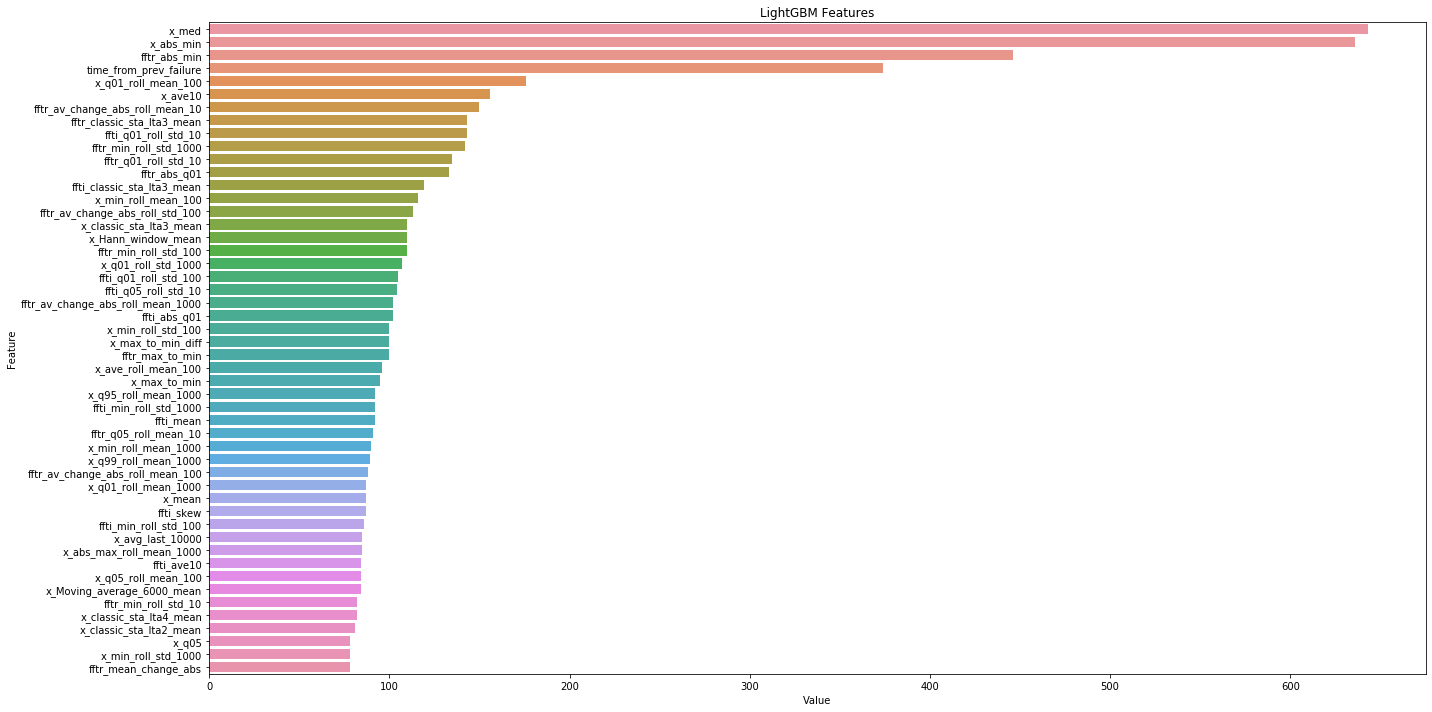

In [14]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [15]:
discriminators = list(feature_imp.sort_values(by="Value", ascending=False).Feature.head(250))
discriminators

['x_med',
 'x_abs_min',
 'fftr_abs_min',
 'time_from_prev_failure',
 'x_q01_roll_mean_100',
 'x_ave10',
 'fftr_av_change_abs_roll_mean_10',
 'fftr_classic_sta_lta3_mean',
 'ffti_q01_roll_std_10',
 'fftr_min_roll_std_1000',
 'fftr_q01_roll_std_10',
 'fftr_abs_q01',
 'ffti_classic_sta_lta3_mean',
 'x_min_roll_mean_100',
 'fftr_av_change_abs_roll_std_100',
 'x_classic_sta_lta3_mean',
 'x_Hann_window_mean',
 'fftr_min_roll_std_100',
 'x_q01_roll_std_1000',
 'ffti_q01_roll_std_100',
 'ffti_q05_roll_std_10',
 'fftr_av_change_abs_roll_mean_1000',
 'ffti_abs_q01',
 'x_min_roll_std_100',
 'x_max_to_min_diff',
 'fftr_max_to_min',
 'x_ave_roll_mean_100',
 'x_max_to_min',
 'x_q95_roll_mean_1000',
 'ffti_min_roll_std_1000',
 'ffti_mean',
 'fftr_q05_roll_mean_10',
 'x_min_roll_mean_1000',
 'x_q99_roll_mean_1000',
 'fftr_av_change_abs_roll_mean_100',
 'x_q01_roll_mean_1000',
 'x_mean',
 'ffti_skew',
 'ffti_min_roll_std_100',
 'x_avg_last_10000',
 'x_abs_max_roll_mean_1000',
 'ffti_ave10',
 'x_q05_rol

In [16]:
df_concat = X_concat.copy()

In [17]:
df_concat['target'] = y_concat
df_concat['oof_pred'] = oof

In [18]:
df_trained = df_concat[df_concat.target == 0]
df_trained.shape

(16626, 384)

In [19]:
df_trained_sorted = df_trained.sort_values(by='oof_pred', ascending=False)
df_trained_sorted.head()

,x_mean,x_std,x_max,x_min,x_mean_change_abs,x_abs_max,x_abs_min,x_std_first_50000,x_std_last_50000,x_std_first_10000,...,ffti_min_roll_mean_1000,ffti_q01_roll_mean_1000,ffti_q05_roll_mean_1000,ffti_q95_roll_mean_1000,ffti_q99_roll_mean_1000,ffti_av_change_abs_roll_mean_1000,ffti_abs_max_roll_mean_1000,time_from_prev_failure,target,oof_pred
7838,1.591616e-17,6.907472,106.975833,-110.024167,-0.000040,110.024167,0.024167,7.141820,5.462326,8.198000,...,-204.209474,-75.201724,-42.273729,42.272552,75.201724,0.000980,204.209474,9.678009,0,0.557664
2446,6.063298e-18,8.737661,138.055993,-147.944007,0.000000,147.944007,0.055993,8.809862,11.160516,6.973871,...,-174.822092,-83.417039,-43.078836,43.078836,83.417039,0.000514,174.822092,9.302365,0,0.517562
14891,5.608551e-17,7.196323,145.027107,-162.972893,-0.000013,162.972893,0.027107,7.874759,8.042202,3.156894,...,-137.588702,-61.118459,-38.975400,38.975400,61.118459,-0.000082,137.588702,10.223318,0,0.515157
2586,-2.751221e-16,6.467274,99.040660,-149.959340,-0.000033,149.959340,0.040660,5.049795,8.868426,3.197058,...,-122.107878,-70.536835,-43.608505,43.608505,70.536835,0.000102,122.107878,8.128183,0,0.505886
14948,-1.023182e-16,7.372921,182.968020,-184.031980,0.000033,184.031980,0.031980,7.421068,8.312373,6.881937,...,-166.611669,-81.153549,-47.072616,47.072616,81.153549,0.000397,166.611669,8.591908,0,0.498655


In [20]:
df_trained.to_pickle(data_dir / 'df_xtrain_stratified_v5.pickle')

In [21]:
(df_trained
    .sort_values(by='oof_pred', ascending=True)[['target', 'oof_pred']]
    .tail(8000)
 ).iloc[4000:4010]

,target,oof_pred
2054,0,0.171950
7166,0,0.171978
14939,0,0.172038
397,0,0.172046
9331,0,0.172075
10588,0,0.172078
8945,0,0.172082
4379,0,0.172133
933,0,0.172177
3427,0,0.172192


In [22]:
(df_trained
    .sort_values(by='oof_pred', ascending=True)[['target', 'oof_pred']]
    .head(500)
    .index.values
 )

array([214, 13395, 4087, 5125, 1416, 9894, 13438, 10141, 3174, 14396,
       12397, 4958, 5086, 8276, 3998, 3824, 8300, 115, 13231, 9983, 12335,
       11141, 12690, 8314, 215, 1395, 16271, 10099, 10153, 10014, 14402,
       11386, 8036, 8357, 213, 10418, 5859, 814, 12200, 129, 5336, 10140,
       5311, 13184, 2833, 12813, 13412, 114, 13316, 118, 4977, 5886,
       14065, 6791, 1557, 3713, 13186, 5906, 11021, 11347, 11289, 8250,
       10124, 5787, 13537, 16246, 14290, 5291, 9345, 5329, 764, 9925, 869,
       3751, 1398, 5039, 8270, 1505, 8852, 8981, 11191, 8062, 1350, 206,
       1331, 5194, 10209, 221, 8274, 3849, 5782, 1426, 1397, 5103, 12313,
       13293, 5856, 8280, 5240, 14140, 5084, 16600, 10115, 5047, 9018,
       13467, 5292, 9421, 211, 12372, 9000, 5858, 13185, 5783, 279, 3831,
       10001, 12556, 6811, 8046, 11299, 761, 12574, 222, 5655, 2818, 8244,
       11985, 9272, 8044, 8987, 2887, 2770, 7267, 1428, 11027, 5677, 1173,
       7241, 5695, 11174, 14377, 5148, 3763, 10286

In [23]:
df_tested = df_concat[df_concat.target == 1]
df_tested.shape

(2624, 384)

In [24]:
df_tested.sort_values(by='oof_pred', ascending=True)[['target', 'oof_pred']].iloc[1000:1010]

,target,oof_pred
seg_d42c77,1,0.152147
seg_5bdb47,1,0.152217
seg_bd31bf,1,0.152279
seg_89791c,1,0.152766
seg_d59e4e,1,0.153099
seg_16566c,1,0.153150
seg_b8fd73,1,0.153175
seg_edecaa,1,0.153177
seg_ecdca4,1,0.153267
seg_1fa983,1,0.153562
